# Deep Q-Learning

This notebook is part of **[Edreate.com’s Deep Reinforcement Learning Course](https://edreate.com/courses/deep-reinforcement-learning/)**.  
Here you’ll find the **codebase** used in the lessons.
<p align="left">
  <a href="https://edreate.com/courses/deep-reinforcement-learning/">
    <img src="https://raw.githubusercontent.com/edreate/Brand-Identity-Media/main/Logo/RGB/Logo/SVG/EdReate_Logo.svg" alt="EdReate Logo" width="100"/>
  </a>
</p>

👉 For the **full learning experience** with in-depth writeups, mathematical formulas, video explanations, and structured chapters, visit the course page:

🔗 [https://edreate.com/courses/deep-reinforcement-learning/](https://edreate.com/courses/deep-reinforcement-learning/)

---

### Related Chapters

- [Deep Q-Learning: Scaling Beyond Q-Tables](https://edreate.com/courses/deep-reinforcement-learning/deep-q-learning/deep-q-learning-scaling-beyond-q-tables/)  
- [Training a Deep Q-Network in PyTorch on LunarLander](https://edreate.com/courses/deep-reinforcement-learning/deep-q-learning/training-a-deep-q-network-in-pytorch-on-lunarlander/)

## 1. Gymnasium Environment Setup

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [27]:
# Initialize environment (discrete actions, RGB rendering mode)
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# --- Actions ---
n_actions = env.action_space.n
print(f"\nNumber of possible actions: {n_actions}")

# --- Observations ---
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

# --- Current State ---
print("Initial state:", state)

# --- Data Types (State) ---
print("\nState container type:", type(state))
print("Element data type:", type(state[0]))


Number of possible actions: 4
Number of state observations: 8
Initial state: [-0.00447016  1.4108083  -0.4528007  -0.0049781   0.00518666  0.10256618
  0.          0.        ]

State container type: <class 'numpy.ndarray'>
Element data type: <class 'numpy.float32'>


### Visualize the environment

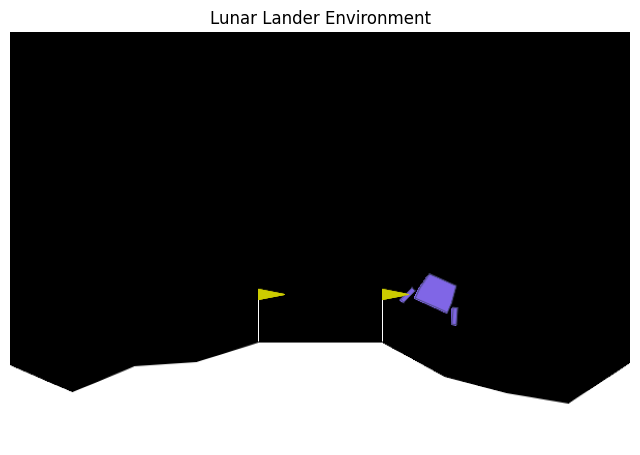

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

# Take 50 steps with action=0 (do nothing) to advance the simulation
for i in range(50):
    env.step(action=0)

# Render the environment as an RGB image (current state of the simulator)
frame = env.render()

# Plot the rendered frame using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## 2. Deep Q Network Components for Training

### 2.1 Replay Buffer

In [4]:
from collections import deque
from dataclasses import dataclass
from typing import Deque, List
import random
import numpy as np
from numpy.typing import NDArray


@dataclass
class Transition:
    """A single experience step in the environment."""

    state: NDArray[np.float32]
    action: int
    next_state: NDArray[np.float32]
    reward: float
    done: bool


class ReplayBuffer:
    """Fixed-size buffer to store and sample transitions for experience replay."""

    def __init__(self, capacity: int):
        """Initialize the buffer with a maximum capacity."""
        self.memory: Deque[Transition] = deque(maxlen=capacity)

    def push(self, transition: Transition) -> None:
        """Store a new transition in the buffer."""
        self.memory.append(transition)

    def sample(self, batch_size: int) -> List[Transition]:
        """Randomly sample a batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the number of stored transitions."""
        return len(self.memory)

### 2.2 Neural Network: Online and Target Q-Network

In [5]:
import torch
import torch.nn as nn
from typing import Tuple


class QNetwork(nn.Module):
    """
    Simple MLP that maps a state vector to Q-values for each discrete action.

    Args:
        n_obs: state dimension
        n_actions: number of discrete actions
        hidden_sizes: tuple with hidden layer sizes
    """

    def __init__(
        self, n_obs: int, n_actions: int, hidden_sizes: Tuple[int, int] = (256, 256)
    ) -> None:
        super().__init__()
        h1, h2 = hidden_sizes
        self.net = nn.Sequential(
            nn.Linear(n_obs, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, n_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [6]:
@torch.no_grad()
def soft_update(target_net: nn.Module, online_net: nn.Module, tau: float) -> None:
    """Polyak averaging."""
    for p_t, p in zip(target_net.parameters(), online_net.parameters()):
        p_t.data.lerp_(p.data, tau)

### 2.3 Exploration: Epsilon Greedy Policy

In [7]:
import math


class EpsilonScheduler:
    """Exponential decay schedule."""

    def __init__(self, eps_start: float, eps_end: float, decay: int) -> None:
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.decay = decay
        self.t = 0  # step counter

    def step(self) -> float:
        eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-self.t / self.decay)
        self.t += 1
        return eps

In [8]:
def select_action_epsilon_greedy(
    q_net: nn.Module,
    state_np: NDArray[np.float32],
    n_actions: int,
    eps: float,
    device: torch.device,
) -> int:
    """Choose an action using epsilon-greedy.

    Args:
        q_net:   policy network
        state_np: 1D state array (n_obs,)
        n_actions: discrete action count
        eps: exploration rate
        device: torch device for model forward
    Returns:
        action (int)
    """

    # Exploration: Take random action
    if random.random() < eps:
        return random.randrange(n_actions)

    # Exploitation: Choose best action
    state_t = torch.as_tensor(state_np, dtype=torch.float32, device=device).unsqueeze(
        0
    )  # (1, n_obs)
    with torch.inference_mode():
        q_values = q_net(state_t)  # (1, n_actions)
        action = int(torch.argmax(q_values, dim=1).item())
    return action

### 2.4 Huber Loss

In [9]:
# Loss Function: Huber Loss
criterion = nn.SmoothL1Loss()

## 3. The DQN Algorithm - Step by Step

We need to choose the hardware for training, options include CPU, CUDA for NVIDIA GPUs, and MPS for Apple Silicon (Macs).

In [10]:
seed = 42

# PyTorch
torch.manual_seed(seed)

# NumPy
np.random.seed(seed)

# Python's random
random.seed(seed)

In [11]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device: ", device)

Using device:  mps


### Training Config

We also need parameters for training also sometimes called hyperparameters in deep learning.

In [12]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class DQNTrainingConfig:
    seed: int = 42
    total_episodes: int = 500
    replay_buffer_capacity: int = 50_000
    batch_size: int = 128
    gamma: float = 0.99
    lr: float = 1e-4
    tau: float = 5e-3
    eps_start: float = 0.9
    eps_end: float = 0.05
    eps_decay: int = 1000
    grad_clip_norm: Optional[float] = 10.0  # set None to disable
    eval_episodes: int = 5
    max_steps_per_episode: int = 1000


training_config = DQNTrainingConfig()

### 3.1 Initilizations

In [13]:
# Neural Networks
online_q = QNetwork(n_observations, n_actions).to(device)
target_q = QNetwork(n_observations, n_actions).to(device)

# before starting to train start with exact same parameters/weights
target_q.load_state_dict(online_q.state_dict())

# Replay Buffer
replay_buffer = ReplayBuffer(training_config.replay_buffer_capacity)

In [14]:
# Optimizer
import torch.optim as optim

optimizer = optim.AdamW(online_q.parameters(), lr=training_config.lr, amsgrad=True)

In [15]:
# Epsilon Scheduler
eps_scheduler = EpsilonScheduler(
    training_config.eps_start, training_config.eps_end, training_config.eps_decay
)

In [16]:
def compute_td_targets(
    target_q_net: nn.Module,
    non_final_next_states: torch.Tensor,
    non_final_mask: torch.Tensor,
    rewards: torch.Tensor,
    dones: torch.Tensor,
    gamma: float,
) -> torch.Tensor:
    """Compute one-step TD targets (no gradients through target network).

    Shapes:
        rewards:   (B,)
        dones:     (B,) in {0,1}
        returns:   (B,)
    """
    batch_size = rewards.shape[0]
    next_state_values = torch.zeros(batch_size, device=rewards.device)

    if non_final_next_states.numel() > 0:
        with torch.inference_mode():
            max_next_q = target_q_net(non_final_next_states).max(dim=1).values  # (num_non_final,)
        next_state_values[non_final_mask] = max_next_q

    targets = rewards + gamma * (1.0 - dones) * next_state_values
    return targets  # (B,)

In [17]:
def dqn_loss(
    online_q_net: nn.Module,
    states: torch.Tensor,
    actions: torch.Tensor,
    targets: torch.Tensor,
    criterion: nn.Module,
) -> torch.Tensor:
    """Compute Smooth L1 (Huber) loss on TD errors.

    Shapes:
        states:   (B, n_obs)
        actions:  (B, 1) int64
        targets:  (B,)
        returns:  scalar loss
    """
    q_values = online_q_net(states)  # (B, n_actions)
    q_sa = q_values.gather(1, actions).squeeze(1)  # (B,)
    return criterion(q_sa, targets)

In [18]:
from typing import Iterable


def sample_replay_buffer_for_training(
    replay_buffer, training_config: DQNTrainingConfig, device: torch.device
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample a batch from `replay_buffer` and convert to tensors for DQN training.

    Returns:
        states_t                 : (B, *state_shape) float32
        actions_t                : (B, 1) long
        rewards_t                : (B,) float32
        non_final_next_states_t  : (N, *state_shape) float32  [N <= B]
        non_final_mask           : (B,) bool
        dones_t                  : (B,) float32  (1.0 if done else 0.0)
    """
    batch: Iterable[Transition] = replay_buffer.sample(training_config.batch_size)

    # Unzip fields
    states, actions, next_states, rewards, dones = zip(
        *[(t.state, t.action, t.next_state, t.reward, t.done) for t in batch]
    )

    # Core tensors
    states_t = torch.as_tensor(np.stack(states), dtype=torch.float32, device=device)
    actions_t = torch.as_tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32, device=device)
    dones_t = torch.as_tensor(dones, dtype=torch.float32, device=device)

    # Mask and pack only non-final next states
    non_final_mask = torch.as_tensor(
        [ns is not None for ns in next_states], dtype=torch.bool, device=device
    )

    if non_final_mask.any().item():
        non_final_next_states_t = torch.as_tensor(
            np.stack([ns for ns in next_states if ns is not None]),
            dtype=torch.float32,
            device=device,
        )
    else:
        # Safe placeholder (won’t be indexed when mask is all False)
        state_dim = states_t.shape[1:]
        non_final_next_states_t = torch.empty((0, *state_dim), dtype=torch.float32, device=device)

    return (
        states_t,
        actions_t,
        rewards_t,
        non_final_next_states_t,
        non_final_mask,
        dones_t,
    )

In [19]:
def optimize_dqn_step(
    *,
    replay_buffer: ReplayBuffer,
    online_q: nn.Module,
    target_q: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    training_config: DQNTrainingConfig,
    device: torch.device,
) -> Optional[float]:
    """
    One gradient step on a minibatch from replay.

    Pipeline:
        - sample (B transitions) -> tensors on device
        - compute targets y_t using target network
        - compute loss Huber(Q_theta - y)
        - backprop, (optionally) clip grads, optimizer step
        - soft-update target by tau

    Returns:
        loss value (float) or None if not enough data.
    """
    if len(replay_buffer) < training_config.batch_size:
        return None

    states, actions, rewards, non_final_next_states, non_final_mask, dones = (
        sample_replay_buffer_for_training(
            replay_buffer=replay_buffer, training_config=training_config, device=device
        )
    )

    targets = compute_td_targets(
        target_q_net=target_q,
        non_final_next_states=non_final_next_states,
        non_final_mask=non_final_mask,
        rewards=rewards,
        dones=dones,
        gamma=training_config.gamma,
    )

    loss = dqn_loss(
        online_q_net=online_q,
        states=states,
        actions=actions,
        targets=targets,
        criterion=criterion,
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    if training_config.grad_clip_norm is not None:
        nn.utils.clip_grad_norm_(online_q.parameters(), max_norm=training_config.grad_clip_norm)

    optimizer.step()
    soft_update(target_q, online_q, training_config.tau)

    return float(loss.item())

In [20]:
def train_dqn(
    *,
    training_config: DQNTrainingConfig,
    device: torch.device,
    env: gym.Env,
    n_actions: int,
    criterion: nn.Module,
    optimizer: nn.Module,
    eps_scheduler: EpsilonScheduler,
) -> Tuple[nn.Module, List[float], List[float]]:
    episode_rewards: List[float] = []
    episode_lengths: List[int] = []

    total_steps = 0

    for ep in range(training_config.total_episodes):
        obs, _ = env.reset()
        ep_reward = 0.0

        for t in range(training_config.max_steps_per_episode):
            eps = eps_scheduler.step()
            action = select_action_epsilon_greedy(
                q_net=online_q,
                state_np=np.asarray(obs, dtype=np.float32),
                n_actions=n_actions,
                eps=eps,
                device=device,
            )

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = bool(terminated or truncated)

            transition = Transition(
                state=np.asarray(obs, dtype=np.float32),
                action=int(action),
                reward=float(reward),
                next_state=(np.asarray(next_obs, dtype=np.float32) if not done else None),
                done=done,
            )

            # Store on CPU
            replay_buffer.push(transition=transition)

            loss_val = optimize_dqn_step(
                replay_buffer=replay_buffer,
                online_q=online_q,
                target_q=target_q,
                optimizer=optimizer,
                criterion=criterion,
                training_config=training_config,
                device=device,
            )

            ep_reward += reward
            obs = next_obs
            total_steps += 1

            if done:
                break

        episode_rewards.append(ep_reward)
        episode_lengths.append(t + 1)

        if (ep + 1) % 50 == 0 or ep == 0:
            avg_r = np.mean(episode_rewards[-25:])
            print(
                f"[Episode {ep + 1:4d}]  len={t + 1:4d}  return={ep_reward:8.2f}  avg25={avg_r:8.2f}"
            )

    env.close()
    return online_q, episode_rewards, episode_lengths

## Evaluation

In [21]:
@torch.no_grad()
def evaluate_policy(
    q_net: nn.Module,
    training_config: DQNTrainingConfig,
    device: torch.device,
    env: gym.Env,
) -> float:
    """
    Run a few evaluation episodes with greedy actions (ε=0).
    Returns mean return.
    """
    total = 0.0

    for _ in range(training_config.eval_episodes):
        obs, _ = env.reset()
        ep_r = 0.0
        for _ in range(training_config.max_steps_per_episode):
            s = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            q = q_net(s)
            action = int(torch.argmax(q, dim=1).item())
            obs, r, terminated, truncated, _ = env.step(action)
            ep_r += r
            if terminated or truncated:
                break
        total += ep_r

    env.close()
    mean_r = total / training_config.eval_episodes
    print(f"[Eval] mean return over {training_config.eval_episodes} episodes: {mean_r:.2f}")
    return mean_r

### Training

In [22]:
online_q, episode_rewards, episode_lengths = train_dqn(
    training_config=training_config,
    device=device,
    env=env,
    n_actions=n_actions,
    criterion=criterion,
    optimizer=optimizer,
    eps_scheduler=eps_scheduler,
)

[Episode    1]  len=  93  return= -181.63  avg25= -181.63
[Episode   50]  len=1000  return=  -54.14  avg25=  -61.12
[Episode  100]  len= 436  return=  218.53  avg25=   19.73
[Episode  150]  len=1000  return=   -2.75  avg25=   82.03
[Episode  200]  len= 415  return=  251.25  avg25=  155.58
[Episode  250]  len= 437  return=  215.58  avg25=  231.76
[Episode  300]  len= 332  return=  290.29  avg25=  225.16
[Episode  350]  len= 351  return=  250.61  avg25=  253.03
[Episode  400]  len= 368  return=  283.46  avg25=  244.68
[Episode  450]  len= 558  return=  216.35  avg25=  245.01
[Episode  500]  len= 301  return=  228.06  avg25=  231.21


### Evaluation

In [23]:
target_q.to(device)
mean_reward = evaluate_policy(target_q, training_config, device, env)

[Eval] mean return over 5 episodes: 237.05


## Visualize Training Results

In [24]:
from plot_rl_results import plot_training_statistics

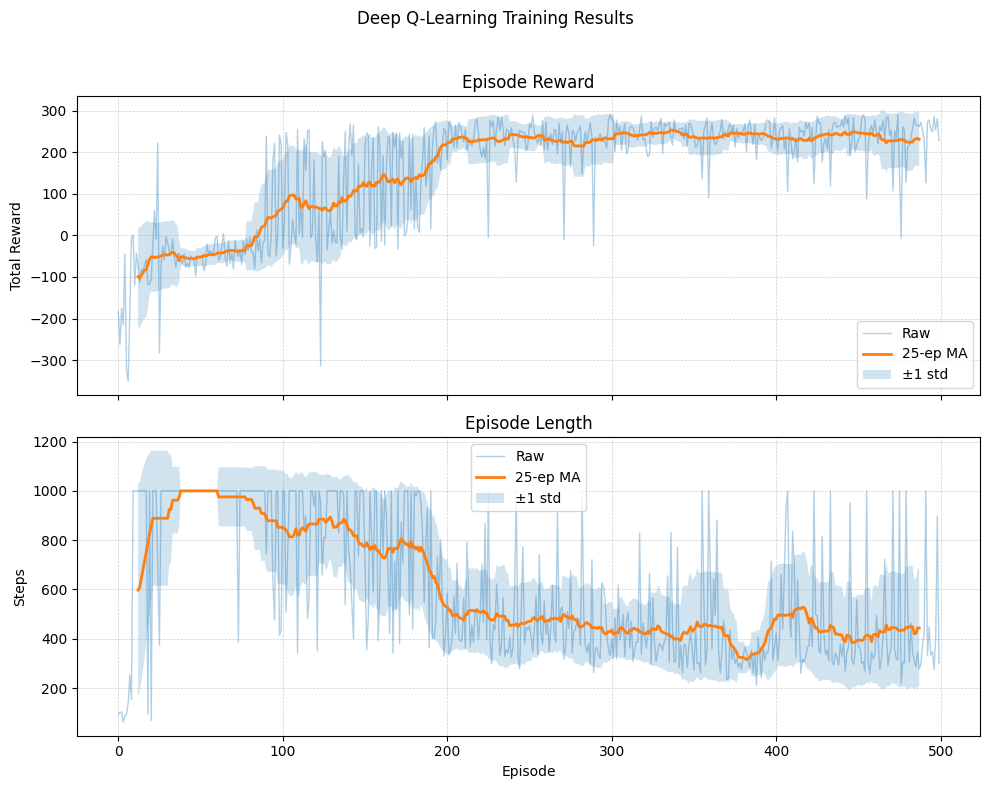

In [25]:
plot_training_statistics(
    episode_rewards=episode_rewards,
    episode_lengths=episode_lengths,
    title="Deep Q-Learning Training Results",
    save_path="deep_q_learning_training_results",
    window=25,
)

In [26]:
from model_saver import save_model_pytorch, save_lunar_model_onnx

# Save Network to Disk
# We will save target_q network as that is what we were training indirectly
save_model_pytorch(target_q, "trained_networks_lunar_lander/deep_q_network_lunar_lander")

save_lunar_model_onnx(target_q, "trained_networks_lunar_lander/deep_q_network_lunar_lander")

✅ Model weights saved to /Users/ibad/Desktop/ft_productivity_helpers/RL_Learn/trained_networks_lunar_lander/deep_q_network_lunar_lander_2025-09-13_21-12.pth
✅ Lunar Lander model exported to /Users/ibad/Desktop/ft_productivity_helpers/RL_Learn/trained_networks_lunar_lander/deep_q_network_lunar_lander_2025-09-13_21-12.onnx


PosixPath('trained_networks_lunar_lander/deep_q_network_lunar_lander_2025-09-13_21-12.onnx')